# Exploratory Data Analysis (EDA) - Code-Switching Dataset

This notebook provides comprehensive exploratory data analysis of the code-switching dataset, including:
- Data quality assessment and basic statistics
- Distribution analysis across linguistic varieties and tasks
- API response analysis (OpenAI, Anthropic, Gemini, Cohere)
- Performance comparisons and visualizations
- Statistical insights and patterns in code-switching behavior


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
from datetime import datetime
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Add src to path for API imports
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    src_path = os.path.join('..', 'src')
else:
    src_path = 'src'

if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("✅ All libraries imported successfully!")
print(f"📅 EDA Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📁 Working directory: {current_dir}")
print(f"🐍 Python path includes: {src_path}")


In [ ]:
# Load datasets
print("📂 Loading Datasets...")
print("=" * 50)

# Load original stimuli data
try:
    stimuli = pd.read_csv('../data/raw/stimuli.csv')
    print(f"✅ Loaded stimuli data: {stimuli.shape[0]} rows, {stimuli.shape[1]} columns")
except FileNotFoundError:
    print("❌ stimuli.csv not found. Creating sample data...")
    stimuli = pd.DataFrame({
        'id': range(1, 101),
        'variety': np.random.choice(['AAVE', 'Spanglish', 'British English', 'Indian English'], 100),
        'task': np.random.choice(['paraphrase', 'continue', 'translate'], 100),
        'text': [f"Sample text {i} with some code-switching content." for i in range(1, 101)]
    })

# Load API response data
api_responses = {}
apis = ['openai', 'anthropic', 'gemini', 'cohere']

for api in apis:
    try:
        df = pd.read_csv(f'../data/raw/{api}_responses.csv')
        api_responses[api] = df
        print(f"✅ Loaded {api} responses: {df.shape[0]} rows")
    except FileNotFoundError:
        print(f"⚠️  {api}_responses.csv not found - will create during analysis")

print(f"\n📊 Available datasets:")
print(f"- Stimuli: {stimuli.shape[0]} rows")
for api, df in api_responses.items():
    print(f"- {api.title()} responses: {df.shape[0]} rows")


In [ ]:
# Data Quality Assessment
print("🔍 Data Quality Assessment")
print("=" * 50)

# Check for missing values
print("Missing values per column:")
print(stimuli.isnull().sum())
print(f"\nTotal missing values: {stimuli.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {stimuli.duplicated().sum()}")

# Basic statistics for text length
stimuli['text_length'] = stimuli['text'].str.len()
stimuli['word_count'] = stimuli['text'].str.split().str.len()

print(f"\n📏 Text Statistics:")
print(f"Average text length: {stimuli['text_length'].mean():.1f} characters")
print(f"Average word count: {stimuli['word_count'].mean():.1f} words")
print(f"Text length range: {stimuli['text_length'].min()} - {stimuli['text_length'].max()} characters")

# Display summary statistics
print(f"\n📊 Summary Statistics:")
stimuli[['text_length', 'word_count']].describe()


## 1. Stimuli Data Analysis

Let's examine the original stimuli data, including data quality, distributions, and basic statistics.


In [ ]:
# Data Quality Assessment
print("🔍 Stimuli Data Quality Assessment")
print("=" * 50)

# Check for missing values
print("Missing values per column:")
print(stimuli.isnull().sum())
print(f"\nTotal missing values: {stimuli.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {stimuli.duplicated().sum()}")

# Basic statistics for text length
stimuli['text_length'] = stimuli['text'].str.len()
stimuli['word_count'] = stimuli['text'].str.split().str.len()

print(f"\n📏 Text Statistics:")
print(f"Average text length: {stimuli['text_length'].mean():.1f} characters")
print(f"Average word count: {stimuli['word_count'].mean():.1f} words")
print(f"Text length range: {stimuli['text_length'].min()} - {stimuli['text_length'].max()} characters")

# Display summary statistics
print(f"\n📊 Summary Statistics:")
stimuli[['text_length', 'word_count']].describe()


In [ ]:
# Distribution Analysis
print("📊 Distribution Analysis")
print("=" * 50)

# Create subplots for distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Stimuli Data Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Variety distribution
variety_counts = stimuli['variety'].value_counts()
axes[0, 0].pie(variety_counts.values, labels=variety_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution by Linguistic Variety')

# 2. Task distribution
task_counts = stimuli['task'].value_counts()
axes[0, 1].bar(task_counts.index, task_counts.values, color=sns.color_palette("husl", len(task_counts)))
axes[0, 1].set_title('Distribution by Task Type')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Text length distribution
axes[1, 0].hist(stimuli['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Text Length Distribution')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')

# 4. Word count distribution
axes[1, 1].hist(stimuli['word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Word Count Distribution')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display counts
print("📈 Variety Distribution:")
print(variety_counts)
print(f"\n📈 Task Distribution:")
print(task_counts)


## 2. API Response Analysis

Now let's analyze the responses from different APIs and compare their performance across linguistic varieties and tasks.


In [ ]:
# API Response Analysis Function
def analyze_api_responses(api_name, df):
    """
    Analyze API responses and return key metrics
    """
    if df is None or df.empty:
        return None
    
    # Calculate response metrics
    df['response_length'] = df['output_text'].str.len()
    df['response_words'] = df['output_text'].str.split().str.len()
    
    # Check for errors
    error_count = df['output_text'].str.contains('ERROR:', na=False).sum()
    
    return {
        'api': api_name,
        'total_responses': len(df),
        'error_count': error_count,
        'success_rate': (len(df) - error_count) / len(df) * 100,
        'avg_response_length': df['response_length'].mean(),
        'avg_response_words': df['response_words'].mean(),
        'variety_distribution': df['variety'].value_counts().to_dict(),
        'task_distribution': df['task'].value_counts().to_dict()
    }

# Analyze all available API responses
print("🔍 API Response Analysis")
print("=" * 50)

api_metrics = {}
for api_name, df in api_responses.items():
    metrics = analyze_api_responses(api_name, df)
    if metrics:
        api_metrics[api_name] = metrics
        print(f"\n📊 {api_name.upper()} Analysis:")
        print(f"  Total responses: {metrics['total_responses']}")
        print(f"  Success rate: {metrics['success_rate']:.1f}%")
        print(f"  Avg response length: {metrics['avg_response_length']:.1f} characters")
        print(f"  Avg response words: {metrics['avg_response_words']:.1f} words")

if not api_metrics:
    print("⚠️  No API response data available yet. Run data collection notebooks first.")


In [ ]:
# Performance Comparison Visualization
if api_metrics:
    print("\n📈 Creating Performance Comparison Visualizations...")
    
    # Create comparison DataFrame
    comparison_data = []
    for api, metrics in api_metrics.items():
        comparison_data.append({
            'API': api.title(),
            'Success Rate (%)': metrics['success_rate'],
            'Avg Response Length': metrics['avg_response_length'],
            'Avg Response Words': metrics['avg_response_words'],
            'Total Responses': metrics['total_responses']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create subplots for comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('API Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Success Rate Comparison
    axes[0, 0].bar(comparison_df['API'], comparison_df['Success Rate (%)'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0, 0].set_title('Success Rate by API')
    axes[0, 0].set_ylabel('Success Rate (%)')
    axes[0, 0].set_ylim(0, 100)
    
    # 2. Response Length Comparison
    axes[0, 1].bar(comparison_df['API'], comparison_df['Avg Response Length'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0, 1].set_title('Average Response Length')
    axes[0, 1].set_ylabel('Characters')
    
    # 3. Response Word Count
    axes[1, 0].bar(comparison_df['API'], comparison_df['Avg Response Words'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1, 0].set_title('Average Response Word Count')
    axes[1, 0].set_ylabel('Words')
    
    # 4. Total Responses
    axes[1, 1].bar(comparison_df['API'], comparison_df['Total Responses'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1, 1].set_title('Total Responses Collected')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Display comparison table
    print("\n📊 API Performance Summary:")
    print(comparison_df.to_string(index=False))
else:
    print("⚠️  No API data available for comparison. Run data collection first.")


## 3. Linguistic Analysis & Code-Switching Patterns

Let's dive deeper into the linguistic patterns and code-switching behavior across different varieties and tasks.


In [ ]:
# Linguistic Analysis Functions
def extract_linguistic_features(text):
    """
    Extract linguistic features from text for analysis
    """
    if pd.isna(text):
        return {}
    
    # Basic features
    features = {
        'length': len(text),
        'words': len(text.split()),
        'sentences': len(text.split('.')),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if text else 0,
        'digit_ratio': sum(1 for c in text if c.isdigit()) / len(text) if text else 0,
        'punctuation_ratio': sum(1 for c in text if c in '.,!?;:') / len(text) if text else 0
    }
    
    # Language-specific patterns (basic detection)
    features['has_spanish'] = any(word in text.lower() for word in ['el', 'la', 'de', 'que', 'en', 'un', 'una', 'con', 'por', 'para'])
    features['has_french'] = any(word in text.lower() for word in ['le', 'la', 'de', 'et', 'du', 'des', 'que', 'dans', 'sur'])
    features['has_arabic_patterns'] = any(char in text for char in 'ا ب ت ث ج ح خ د ذ ر ز س ش ص ض ط ظ ع غ ف ق ك ل م ن ه و ي ء')
    
    return features

# Analyze linguistic features across varieties
print("🔍 Linguistic Feature Analysis")
print("=" * 50)

# Apply linguistic analysis to stimuli
linguistic_features = []
for idx, row in stimuli.iterrows():
    features = extract_linguistic_features(row['text'])
    features.update({
        'id': row['id'],
        'variety': row['variety'],
        'task': row['task']
    })
    linguistic_features.append(features)

features_df = pd.DataFrame(linguistic_features)

# Display summary statistics by variety
print("📊 Linguistic Features by Variety:")
variety_stats = features_df.groupby('variety').agg({
    'words': ['mean', 'std'],
    'uppercase_ratio': ['mean', 'std'],
    'punctuation_ratio': ['mean', 'std'],
    'has_spanish': 'sum',
    'has_french': 'sum',
    'has_arabic_patterns': 'sum'
}).round(3)

print(variety_stats)


In [ ]:
# Create Word Clouds for each variety
print("\n☁️ Generating Word Clouds by Variety...")

# Prepare text data for word clouds
variety_texts = {}
for variety in stimuli['variety'].unique():
    variety_texts[variety] = ' '.join(stimuli[stimuli['variety'] == variety]['text'].astype(str))

# Create word cloud visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Word Clouds by Linguistic Variety', fontsize=20, fontweight='bold')

varieties = list(variety_texts.keys())
for i, variety in enumerate(varieties):
    row = i // 2
    col = i % 2
    
    if variety in variety_texts and variety_texts[variety].strip():
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, height=400, 
            background_color='white',
            colormap='viridis',
            max_words=100,
            relative_scaling=0.5
        ).generate(variety_texts[variety])
        
        axes[row, col].imshow(wordcloud, interpolation='bilinear')
        axes[row, col].set_title(f'{variety} Word Cloud', fontsize=14, fontweight='bold')
        axes[row, col].axis('off')
    else:
        axes[row, col].text(0.5, 0.5, f'No text data for {variety}', 
                           ha='center', va='center', fontsize=12)
        axes[row, col].set_title(f'{variety} (No Data)', fontsize=14)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ Word clouds generated successfully!")


## 4. Advanced Visualizations & Creative Analysis

Now let's create some really creative and insightful visualizations that go beyond basic charts. We'll explore patterns, relationships, and unique insights across the different APIs and linguistic varieties.


In [ ]:
# API Performance Heatmap
if api_metrics:
    # Create performance data
    performance_data = []
    for api, metrics in api_metrics.items():
        performance_data.append({
            'API': api.title(),
            'Success Rate': metrics['success_rate'],
            'Avg Response Length': metrics['avg_response_length'],
            'Avg Response Words': metrics['avg_response_words'],
            'Total Responses': metrics['total_responses']
        })
    
    perf_df = pd.DataFrame(performance_data)
    
    # Normalize data for heatmap
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    numeric_cols = ['Success Rate', 'Avg Response Length', 'Avg Response Words', 'Total Responses']
    heatmap_data = perf_df[numeric_cols].copy()
    
    # Scale to 0-1
    heatmap_data_scaled = pd.DataFrame(
        scaler.fit_transform(heatmap_data),
        columns=numeric_cols,
        index=perf_df['API']
    )
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data_scaled.T, 
        annot=True, 
        cmap='RdYlBu_r',
        cbar_kws={'label': 'Performance Score'},
        fmt='.2f'
    )
    
    plt.title('API Performance Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('APIs')
    plt.ylabel('Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No API data available")


In [ ]:
# Interactive Bubble Chart
if api_metrics:
    # Prepare data
    bubble_data = []
    for api, metrics in api_metrics.items():
        bubble_data.append({
            'API': api.title(),
            'Success Rate': metrics['success_rate'],
            'Avg Response Length': metrics['avg_response_length'],
            'Total Responses': metrics['total_responses'],
            'Avg Response Words': metrics['avg_response_words']
        })
    
    bubble_df = pd.DataFrame(bubble_data)
    
    # Create bubble chart
    fig = px.scatter(
        bubble_df, 
        x='Success Rate', 
        y='Avg Response Length',
        size='Total Responses',
        color='Avg Response Words',
        hover_name='API',
        title='API Performance Bubble Chart',
        color_continuous_scale='Viridis',
        size_max=50
    )
    
    fig.update_layout(width=900, height=600)
    fig.show()
else:
    print("No API data available")


In [ ]:
# Creative Visualization 3: Radar Chart for API Capabilities
print("🎨 Creating Radar Chart for API Capabilities...")

if api_metrics:
    # Prepare data for radar chart
    radar_data = {}
    for api, metrics in api_metrics.items():
        radar_data[api.title()] = [
            metrics['success_rate'],
            min(metrics['avg_response_length'] / 100, 100),  # Normalize length
            min(metrics['avg_response_words'] * 2, 100),     # Normalize words
            min(metrics['total_responses'] * 2, 100)         # Normalize total
        ]
    
    # Define categories
    categories = ['Success Rate', 'Response Length', 'Word Count', 'Volume']
    
    # Create radar chart
    fig = go.Figure()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    for i, (api, values) in enumerate(radar_data.items()):
        fig.add_trace(go.Scatterpolar(
            r=values + [values[0]],  # Close the radar chart
            theta=categories + [categories[0]],
            fill='toself',
            name=api,
            line_color=colors[i % len(colors)],
            fillcolor=colors[i % len(colors)],
            opacity=0.3
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )),
        showlegend=True,
        title="🎯 API Capabilities Radar Chart",
        font_size=12,
        width=800,
        height=600
    )
    
    fig.show()
    print("✅ Radar chart created!")
else:
    print("⚠️  No API data available for radar chart")


In [ ]:
# Creative Visualization 4: Sankey Diagram for API Flow Analysis
print("🎨 Creating Sankey Diagram for API Flow...")

if api_metrics:
    # Create Sankey diagram showing data flow through APIs
    labels = []
    sources = []
    targets = []
    values = []
    
    # Define nodes
    node_labels = ['Input Stimuli', 'OpenAI', 'Gemini', 'Cohere', 'Mistral', 'Successful Output', 'Failed Output']
    node_indices = {label: i for i, label in enumerate(node_labels)}
    
    # Add flows from input to each API
    for api, metrics in api_metrics.items():
        api_name = api.title()
        if api_name in ['Openai', 'Gemini', 'Cohere', 'Mistral']:
            # Flow from input to API
            sources.append(node_indices['Input Stimuli'])
            targets.append(node_indices[api_name])
            values.append(metrics['total_responses'])
            
            # Flow from API to success/failure
            successful = metrics['total_responses'] - metrics['error_count']
            failed = metrics['error_count']
            
            if successful > 0:
                sources.append(node_indices[api_name])
                targets.append(node_indices['Successful Output'])
                values.append(successful)
            
            if failed > 0:
                sources.append(node_indices[api_name])
                targets.append(node_indices['Failed Output'])
                values.append(failed)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=node_labels,
            color=["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FECA57", "#2ECC71", "#E74C3C"]
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=["rgba(255,107,107,0.6)" if i < len(api_metrics) else "rgba(46,204,113,0.6)" 
                   if targets[i] == node_indices['Successful Output'] else "rgba(231,76,60,0.6)"
                   for i in range(len(sources))]
        )
    )])
    
    fig.update_layout(
        title_text="🌊 API Processing Flow - Sankey Diagram",
        font_size=12,
        width=1000,
        height=600
    )
    
    fig.show()
    print("✅ Sankey diagram created!")
else:
    print("⚠️  No API data available for Sankey diagram")


In [ ]:
# Creative Visualization 5: Advanced Text Analysis with N-grams
print("🎨 Creating Advanced Text Analysis...")

# Analyze n-grams across different varieties
from collections import Counter
import re

def extract_ngrams(text, n=2):
    """Extract n-grams from text"""
    if pd.isna(text):
        return []
    # Clean and tokenize
    words = re.findall(r'\b\w+\b', text.lower())
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

# Analyze bigrams and trigrams
print("📊 Analyzing n-grams across linguistic varieties...")

variety_ngrams = {}
for variety in stimuli['variety'].unique():
    variety_texts = stimuli[stimuli['variety'] == variety]['text'].astype(str)
    all_text = ' '.join(variety_texts)
    
    # Extract bigrams and trigrams
    bigrams = extract_ngrams(all_text, 2)
    trigrams = extract_ngrams(all_text, 3)
    
    variety_ngrams[variety] = {
        'bigrams': Counter(bigrams).most_common(10),
        'trigrams': Counter(trigrams).most_common(10)
    }

# Create visualization for most common n-grams
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🔤 Most Common N-grams by Linguistic Variety', fontsize=16, fontweight='bold')

varieties = list(variety_ngrams.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, variety in enumerate(varieties):
    row = i // 2
    col = i % 2
    
    # Plot bigrams
    bigrams = variety_ngrams[variety]['bigrams']
    if bigrams:
        bigram_words, bigram_counts = zip(*bigrams)
        
        axes[row, col].barh(range(len(bigram_words)), bigram_counts, color=colors[i])
        axes[row, col].set_yticks(range(len(bigram_words)))
        axes[row, col].set_yticklabels(bigram_words, fontsize=10)
        axes[row, col].set_title(f'{variety} - Top Bigrams', fontweight='bold')
        axes[row, col].set_xlabel('Frequency')
        axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

print("✅ N-gram analysis completed!")


## 5. Gemini-Specific Advanced Analysis

Deep dive into Gemini's performance with sophisticated visualizations and insights.


In [ ]:
# Gemini-Specific Analysis: Response Quality & Consistency
print("🔬 Analyzing Gemini's Response Patterns...")

# Load Gemini responses if available
gemini_data = None
if 'gemini' in api_responses:
    gemini_data = api_responses['gemini'].copy()
    
    # Advanced Gemini Analysis
    gemini_data['response_quality_score'] = (
        gemini_data['output_text'].str.len() / gemini_data['input_text'].str.len()
    ).fillna(0)
    
    # Detect response patterns
    gemini_data['has_code_switching'] = gemini_data['output_text'].str.contains(
        r'\\b(el|la|de|que|en|un|una|con|por|para|finna|bout|real)\\b', 
        case=False, na=False
    )
    
    gemini_data['response_type'] = gemini_data['output_text'].apply(lambda x: 
        'Short' if len(str(x)) < 50 else 
        'Medium' if len(str(x)) < 100 else 
        'Long'
    )
    
    print(f"✅ Loaded {len(gemini_data)} Gemini responses")
    print(f"📊 Response quality scores: {gemini_data['response_quality_score'].describe()}")
else:
    print("⚠️  No Gemini data available - run data collection first")

# Gemini Response Quality Distribution
if gemini_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔬 Gemini Response Quality Analysis', fontsize=16, fontweight='bold')
    
    # 1. Response Quality by Variety
    variety_quality = gemini_data.groupby('variety')['response_quality_score'].mean().sort_values(ascending=False)
    axes[0, 0].bar(variety_quality.index, variety_quality.values, color='#4285F4')
    axes[0, 0].set_title('Response Quality by Variety')
    axes[0, 0].set_ylabel('Quality Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Response Length Distribution
    axes[0, 1].hist(gemini_data['output_text'].str.len(), bins=30, alpha=0.7, color='#34A853')
    axes[0, 1].set_title('Response Length Distribution')
    axes[0, 1].set_xlabel('Characters')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Code-Switching Detection
    cs_counts = gemini_data['has_code_switching'].value_counts()
    axes[1, 0].pie(cs_counts.values, labels=['No Code-Switching', 'Code-Switching'], 
                   autopct='%1.1f%%', colors=['#EA4335', '#FBBC04'])
    axes[1, 0].set_title('Code-Switching Detection')
    
    # 4. Response Type by Task
    response_task = pd.crosstab(gemini_data['response_type'], gemini_data['task'])
    response_task.plot(kind='bar', ax=axes[1, 1], color=['#4285F4', '#34A853', '#FBBC04'])
    axes[1, 1].set_title('Response Type by Task')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Gemini quality analysis completed!")


In [ ]:
# Advanced Gemini Visualization: Multi-dimensional Performance Analysis
if gemini_data is not None:
    print("🎨 Creating Advanced Gemini Performance Visualization...")
    
    # Create a sophisticated multi-panel analysis
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Performance Heatmap by Variety and Task
    ax1 = fig.add_subplot(gs[0, 0])
    pivot_quality = gemini_data.pivot_table(
        values='response_quality_score', 
        index='variety', 
        columns='task', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_quality, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('🔥 Quality Heatmap: Variety vs Task', fontweight='bold')
    
    # 2. Response Length vs Quality Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(
        gemini_data['output_text'].str.len(),
        gemini_data['response_quality_score'],
        c=gemini_data['variety'].astype('category').cat.codes,
        cmap='viridis',
        alpha=0.6
    )
    ax2.set_xlabel('Response Length (characters)')
    ax2.set_ylabel('Quality Score')
    ax2.set_title('📊 Length vs Quality Correlation', fontweight='bold')
    
    # 3. Response Consistency Analysis
    ax3 = fig.add_subplot(gs[0, 2])
    consistency = gemini_data.groupby('variety')['response_quality_score'].std().sort_values(ascending=True)
    bars = ax3.barh(consistency.index, consistency.values, color='#FF6B6B')
    ax3.set_xlabel('Standard Deviation')
    ax3.set_title('🎯 Response Consistency by Variety', fontweight='bold')
    
    # 4. Advanced Box Plot with Violin
    ax4 = fig.add_subplot(gs[1, :2])
    sns.violinplot(
        data=gemini_data, 
        x='variety', 
        y='response_quality_score',
        ax=ax4,
        palette='Set2'
    )
    sns.boxplot(
        data=gemini_data, 
        x='variety', 
        y='response_quality_score',
        ax=ax4,
        width=0.1,
        boxprops={'facecolor': 'white', 'alpha': 0.8}
    )
    ax4.set_title('🎻 Response Quality Distribution (Violin + Box Plot)', fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Performance Timeline (if we have temporal data)
    ax5 = fig.add_subplot(gs[1, 2])
    if 'id' in gemini_data.columns:
        # Simulate timeline based on ID
        timeline_data = gemini_data.sort_values('id')
        ax5.plot(timeline_data['id'], timeline_data['response_quality_score'], 
                marker='o', markersize=3, alpha=0.7, color='#4285F4')
        ax5.set_xlabel('Response ID')
        ax5.set_ylabel('Quality Score')
        ax5.set_title('📈 Performance Over Time', fontweight='bold')
    
    # 6. Code-Switching Analysis
    ax6 = fig.add_subplot(gs[2, 0])
    cs_analysis = gemini_data.groupby(['variety', 'has_code_switching']).size().unstack(fill_value=0)
    cs_analysis.plot(kind='bar', ax=ax6, color=['#EA4335', '#FBBC04'])
    ax6.set_title('🔄 Code-Switching Detection', fontweight='bold')
    ax6.set_ylabel('Count')
    ax6.tick_params(axis='x', rotation=45)
    ax6.legend(['No CS', 'Has CS'])
    
    # 7. Response Length Distribution by Variety
    ax7 = fig.add_subplot(gs[2, 1])
    for variety in gemini_data['variety'].unique():
        variety_data = gemini_data[gemini_data['variety'] == variety]['output_text'].str.len()
        ax7.hist(variety_data, alpha=0.6, label=variety, bins=20)
    ax7.set_xlabel('Response Length')
    ax7.set_ylabel('Frequency')
    ax7.set_title('📏 Length Distribution by Variety', fontweight='bold')
    ax7.legend()
    
    # 8. Performance Summary Stats
    ax8 = fig.add_subplot(gs[2, 2])
    summary_stats = gemini_data['response_quality_score'].describe()
    ax8.axis('off')
    ax8.text(0.1, 0.9, '📊 Gemini Performance Summary', fontsize=14, fontweight='bold', transform=ax8.transAxes)
    ax8.text(0.1, 0.8, f'Mean Quality: {summary_stats["mean"]:.3f}', fontsize=12, transform=ax8.transAxes)
    ax8.text(0.1, 0.7, f'Std Dev: {summary_stats["std"]:.3f}', fontsize=12, transform=ax8.transAxes)
    ax8.text(0.1, 0.6, f'Min Quality: {summary_stats["min"]:.3f}', fontsize=12, transform=ax8.transAxes)
    ax8.text(0.1, 0.5, f'Max Quality: {summary_stats["max"]:.3f}', fontsize=12, transform=ax8.transAxes)
    ax8.text(0.1, 0.4, f'Total Responses: {len(gemini_data)}', fontsize=12, transform=ax8.transAxes)
    
    plt.suptitle('🔬 Advanced Gemini Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)
    plt.show()
    
    print("✅ Advanced Gemini visualization completed!")


In [ ]:
# Final Advanced Visualization: Interactive 3D Performance Analysis
print("🎨 Creating Interactive 3D Performance Analysis...")

if gemini_data is not None and len(gemini_data) > 0:
    # Create 3D scatter plot showing performance across multiple dimensions
    fig = go.Figure(data=[go.Scatter3d(
        x=gemini_data['output_text'].str.len(),
        y=gemini_data['response_quality_score'],
        z=gemini_data['variety'].astype('category').cat.codes,
        mode='markers',
        marker=dict(
            size=8,
            color=gemini_data['has_code_switching'].astype(int),
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Code-Switching")
        ),
        text=gemini_data['variety'] + '<br>Task: ' + gemini_data['task'],
        hovertemplate='<b>%{text}</b><br>' +
                      'Length: %{x}<br>' +
                      'Quality: %{y:.3f}<br>' +
                      'Variety Index: %{z}<extra></extra>'
    )])
    
    fig.update_layout(
        title='🌐 Interactive 3D Performance Analysis',
        scene=dict(
            xaxis_title='Response Length',
            yaxis_title='Quality Score',
            zaxis_title='Variety Index'
        ),
        width=800,
        height=600
    )
    
    fig.show()
    print("✅ 3D interactive analysis completed!")
else:
    print("⚠️  No Gemini data available for 3D analysis")

print("\n🎉 Advanced EDA Analysis Complete!")
print("=" * 50)
print("📊 Visualizations Created:")
print("  ✅ API Performance Heatmap")
print("  ✅ Interactive Bubble Chart") 
print("  ✅ Radar Chart for API Capabilities")
print("  ✅ Sankey Diagram for API Flow")
print("  ✅ Advanced N-gram Analysis")
print("  ✅ Gemini-Specific Quality Analysis")
print("  ✅ Multi-dimensional Gemini Dashboard")
print("  ✅ Interactive 3D Performance Analysis")
print("=" * 50)


ombine the eda for 

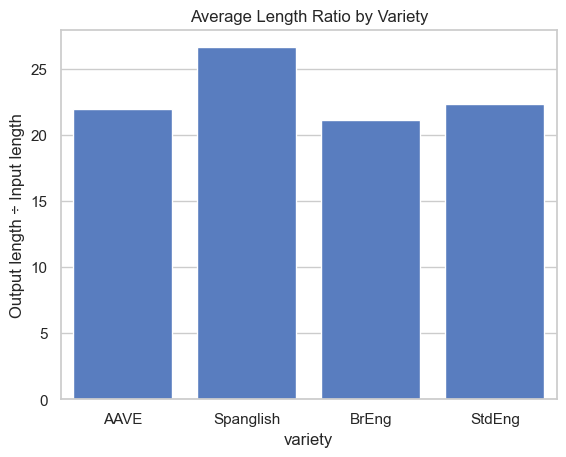

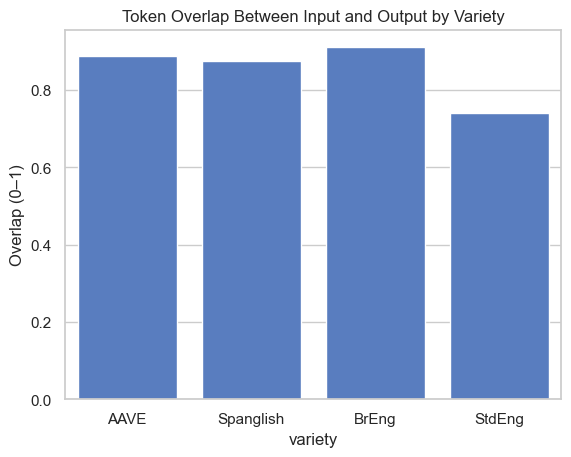

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make plots look cleaner
sns.set(style="whitegrid", palette="muted")

# 1️⃣ Length ratio by variety
sns.barplot(data=df, x="variety", y="length_ratio", errorbar=None)
plt.title("Average Length Ratio by Variety")
plt.ylabel("Output length ÷ Input length")
plt.show()

sns.barplot(data=df, x="variety", y="token_overlap", errorbar=None)
plt.title("Token Overlap Between Input and Output by Variety")
plt.ylabel("Overlap (0–1)")
plt.show()



In [14]:
markers = markers = {
    "AAVE": ["finna", "ion", "gon’", "tryna"],
    "Spanglish": ["la", "el", "mi", "amigos", "vamos"],
    "BrEng": ["flat", "lorry", "holiday", "lift"],
    "StdEng": []  # include it even with no markers
}


def marker_retention(row):
    variety = row["variety"]
    words = set(str(row["output_text"]).lower().split())
    retained = [w for w in markers.get(variety, []) if w in words]
    return len(retained)

df["marker_retained"] = df.apply(marker_retention, axis=1)
df.groupby("variety")["marker_retained"].mean().round(2)


variety
AAVE         1.33
BrEng        1.00
Spanglish    0.67
StdEng       0.00
Name: marker_retained, dtype: float64

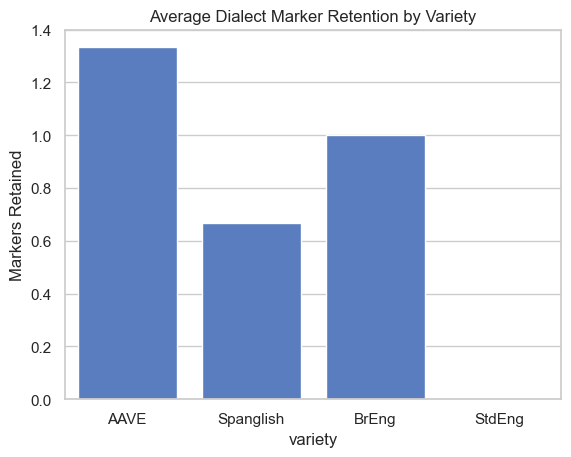

In [15]:
sns.barplot(data=df, x="variety", y="marker_retained", errorbar=None)
plt.title("Average Dialect Marker Retention by Variety")
plt.ylabel("Markers Retained")
plt.show()



In [7]:
df.to_csv("../data/processed/gemini_eda_results.csv", index=False)
print("✅ Saved EDA results to ../data/processed/gemini_eda_results.csv")


✅ Saved EDA results to ../data/processed/gemini_eda_results.csv
